Change the kernel to __newautoriftenv__.

In [84]:
import rasterio as rio
from rasterio.mask import mask
import cv2
import fiona
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import subprocess
import shutil
from scipy.interpolate import interp2d
import glob 

%load_ext jupyternotify

The jupyternotify extension is already loaded. To reload it, use:
  %reload_ext jupyternotify


In [85]:
basepath = '/Volumes/SGlacier/Turner20_21/02_21/out/'
# basepath = '/Users/jukesliu/Documents/TURNER/DATA/IMAGERY/Planet_test/Planet_test_all/'
os.listdir(basepath)

['20210202_203317_12_241c_3B_AnalyticMS_SR_clip_5m.tif',
 '20210213_203852_41_240a_3B_AnalyticMS_SR_clip_5m.tif',
 '20210211_203303_13_2424_3B_AnalyticMS_SR_clip_5m.tif',
 '20210213_200859_1035_3B_AnalyticMS_SR_clip_5m.tif',
 '20210203_205249_69_1064_3B_AnalyticMS_SR_clip_5m.tif',
 '20210202_194905_86_2235_3B_AnalyticMS_SR_clip_5m.tif',
 '20210215_201137_100c_3B_AnalyticMS_SR_clip_5m.tif',
 '20210212_203620_83_241c_3B_AnalyticMS_SR_clip_5m.tif',
 '20210201_201017_1034_3B_AnalyticMS_SR_clip_5m.tif',
 'stitched_by_sat',
 '20210209_205638_73_1058_3B_AnalyticMS_SR_clip_5m.tif',
 '20210215_190733_77_1063_3B_AnalyticMS_SR_clip_5m.tif',
 '20210226_201043_0f22_3B_AnalyticMS_SR_clip_5m.tif',
 '20210214_201535_1032_3B_AnalyticMS_SR_clip_5m.tif',
 '20210223_204007_67_2408_3B_AnalyticMS_SR_clip_5m.tif',
 '20210207_201658_101f_3B_AnalyticMS_SR_clip_5m.tif',
 '20210208_204447_82_225b_3B_AnalyticMS_SR_clip_5m.tif',
 '20210223_195153_37_2262_3B_AnalyticMS_SR_clip_5m.tif',
 '20210214_201529_1032_3B_Ana

# Coregister and stitch all Planet tiles for each image date

In [86]:
# grab unique dates
filelist = os.listdir(basepath); filelist.sort()
unique_dates = []; IDs = []; files = []
for file in filelist:
    if file.startswith('2') and file.endswith('tif'):
        date = file.split('_')[0] # grab the date
        sID = file.split('_')[-6] # grab the satellite ID (4 digit code)
        unique_dates.append(date); IDs.append(sID); files.append(file) # append to list
sorted_dates = list(set(list(zip(unique_dates, IDs)))) # set of the zipped date and ID
sorted_dates.sort() # sorted
print(sorted_dates)

[('20210201', '1034'), ('20210202', '1014'), ('20210202', '1060'), ('20210202', '2235'), ('20210202', '241c'), ('20210202', '2441'), ('20210203', '1064'), ('20210203', '2405'), ('20210203', '2408'), ('20210204', '1059'), ('20210204', '105c'), ('20210205', '1040'), ('20210205', '105c'), ('20210205', '105d'), ('20210205', '2412'), ('20210206', '1057'), ('20210206', '2402'), ('20210206', '240a'), ('20210207', '0e0f'), ('20210207', '101f'), ('20210207', '1066'), ('20210208', '105a'), ('20210208', '225b'), ('20210208', '2441'), ('20210209', '1058'), ('20210209', '240f'), ('20210210', '0f17'), ('20210210', '227a'), ('20210210', '2406'), ('20210211', '1003'), ('20210211', '101f'), ('20210211', '2307'), ('20210211', '2424'), ('20210212', '241c'), ('20210213', '1035'), ('20210213', '106a'), ('20210213', '240a'), ('20210214', '1026'), ('20210214', '1032'), ('20210214', '2426'), ('20210215', '100c'), ('20210215', '1063'), ('20210215', '2414'), ('20210215', '2441'), ('20210216', '1034'), ('2021021

In [87]:
# Grab the first Planet tile for reference CRS and Transform
reftile = rio.open(basepath+files[0])
print(reftile.crs)
print(reftile.transform)
print(reftile.shape)

EPSG:32607
| 4.98, 0.00, 546087.13|
| 0.00,-4.98, 6682892.30|
| 0.00, 0.00, 1.00|
(8315, 8357)


TILES FOR 20210201 1034
['/Volumes/SGlacier/Turner20_21/02_21/out/20210201_201017_1034_3B_AnalyticMS_SR_clip_5m.tif']


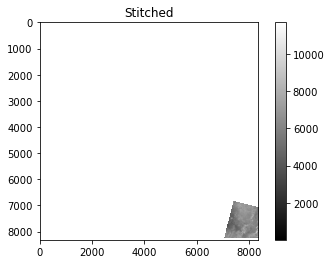

TILES FOR 20210202 1014
['/Volumes/SGlacier/Turner20_21/02_21/out/20210202_201923_1014_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_201924_1014_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_201925_1014_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


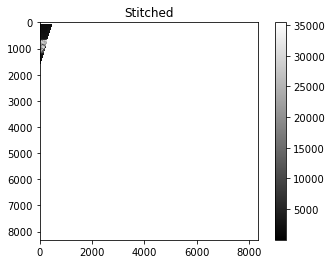

TILES FOR 20210202 1060
['/Volumes/SGlacier/Turner20_21/02_21/out/20210202_205252_72_1060_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_205254_72_1060_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.


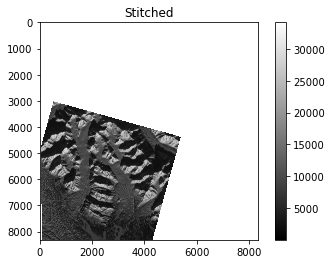

TILES FOR 20210202 2235
['/Volumes/SGlacier/Turner20_21/02_21/out/20210202_194903_65_2235_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_194905_86_2235_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_194908_07_2235_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_194910_28_2235_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


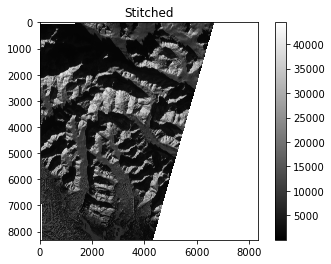

TILES FOR 20210202 241c
['/Volumes/SGlacier/Turner20_21/02_21/out/20210202_203317_12_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_203319_47_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_203321_82_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_203324_17_241c_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


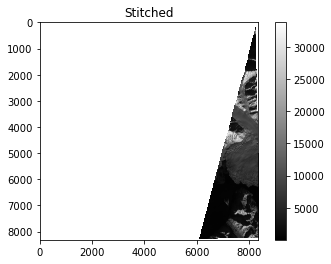

TILES FOR 20210202 2441
['/Volumes/SGlacier/Turner20_21/02_21/out/20210202_195343_78_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_195346_05_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210202_195348_33_2441_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.
Previous tile is larger.


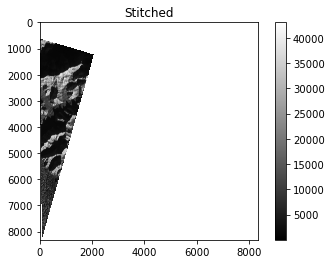

TILES FOR 20210203 1064
['/Volumes/SGlacier/Turner20_21/02_21/out/20210203_205247_69_1064_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_205249_69_1064_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_205251_69_1064_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


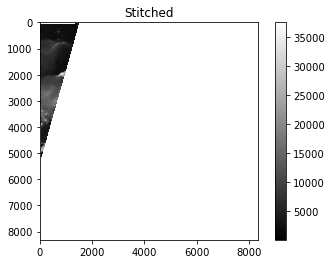

TILES FOR 20210203 2405
['/Volumes/SGlacier/Turner20_21/02_21/out/20210203_203314_98_2405_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_203317_28_2405_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_203319_57_2405_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_203321_87_2405_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


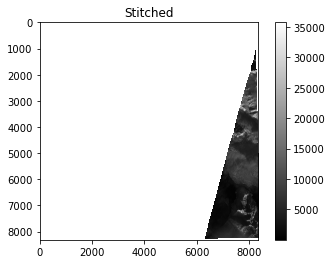

TILES FOR 20210203 2408
['/Volumes/SGlacier/Turner20_21/02_21/out/20210203_204027_66_2408_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_204029_95_2408_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210203_204034_51_2408_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


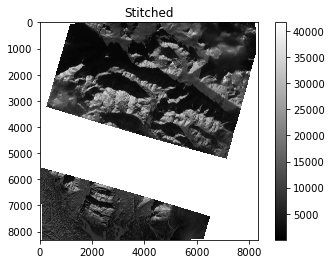

TILES FOR 20210204 1059
['/Volumes/SGlacier/Turner20_21/02_21/out/20210204_205320_74_1059_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210204_205322_74_1059_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210204_205324_74_1059_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


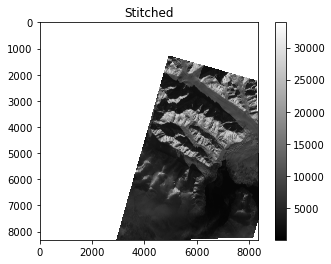

TILES FOR 20210204 105c
['/Volumes/SGlacier/Turner20_21/02_21/out/20210204_202047_09_105c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210204_202048_96_105c_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.


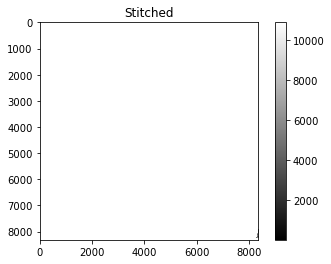

TILES FOR 20210205 1040
['/Volumes/SGlacier/Turner20_21/02_21/out/20210205_200952_1040_3B_AnalyticMS_SR_clip_5m.tif']


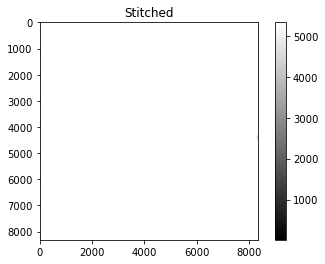

TILES FOR 20210205 105c
['/Volumes/SGlacier/Turner20_21/02_21/out/20210205_202611_80_105c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210205_202613_67_105c_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.


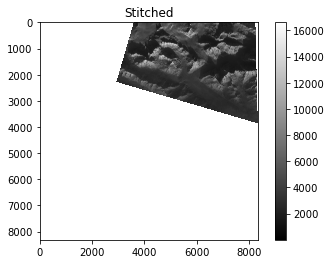

TILES FOR 20210205 105d
['/Volumes/SGlacier/Turner20_21/02_21/out/20210205_205517_71_105d_3B_AnalyticMS_SR_clip_5m.tif']


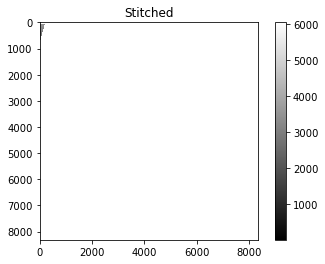

TILES FOR 20210205 2412
['/Volumes/SGlacier/Turner20_21/02_21/out/20210205_204021_91_2412_3B_AnalyticMS_SR_clip_5m.tif']


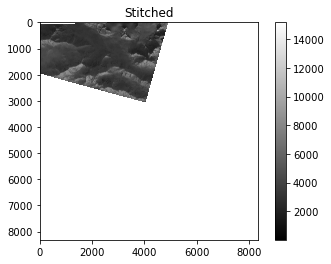

TILES FOR 20210206 1057
['/Volumes/SGlacier/Turner20_21/02_21/out/20210206_205452_75_1057_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210206_205454_75_1057_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.


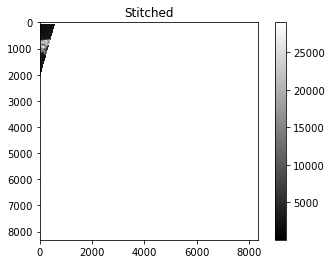

TILES FOR 20210206 2402
['/Volumes/SGlacier/Turner20_21/02_21/out/20210206_203658_36_2402_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210206_203700_64_2402_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.


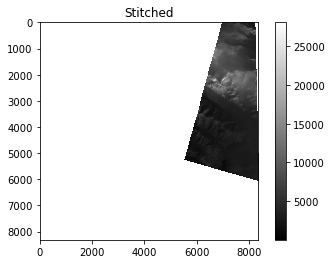

TILES FOR 20210206 240a
['/Volumes/SGlacier/Turner20_21/02_21/out/20210206_204135_32_240a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210206_204137_67_240a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210206_204140_02_240a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210206_204142_37_240a_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


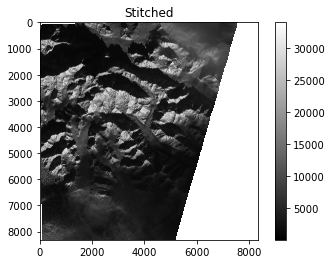

TILES FOR 20210207 0e0f
['/Volumes/SGlacier/Turner20_21/02_21/out/20210207_195308_0e0f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_195309_0e0f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_195310_0e0f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_195313_0e0f_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Current tile is larger.


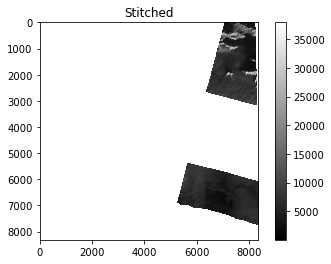

TILES FOR 20210207 101f
['/Volumes/SGlacier/Turner20_21/02_21/out/20210207_201657_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_201658_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_201659_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_201700_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_201701_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_201703_101f_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


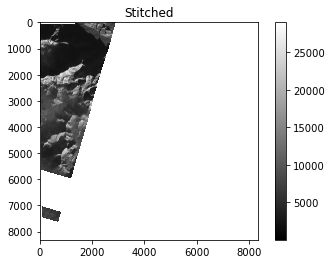

TILES FOR 20210207 1066
['/Volumes/SGlacier/Turner20_21/02_21/out/20210207_205504_72_1066_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_205506_72_1066_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_205508_72_1066_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_205510_72_1066_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210207_205512_72_1066_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


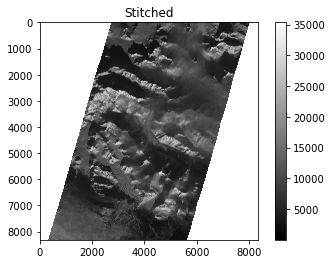

TILES FOR 20210208 105a
['/Volumes/SGlacier/Turner20_21/02_21/out/20210208_205701_17_105a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_205703_18_105a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_205705_20_105a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_205707_21_105a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_205709_22_105a_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


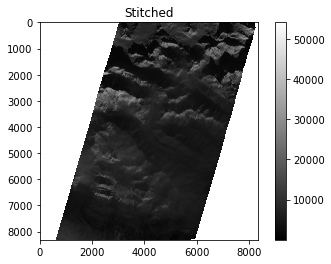

TILES FOR 20210208 225b
['/Volumes/SGlacier/Turner20_21/02_21/out/20210208_204447_82_225b_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_204450_19_225b_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_204452_55_225b_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


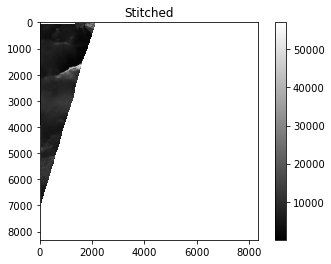

TILES FOR 20210208 2441
['/Volumes/SGlacier/Turner20_21/02_21/out/20210208_200042_65_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_200044_92_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_200047_19_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210208_200049_46_2441_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


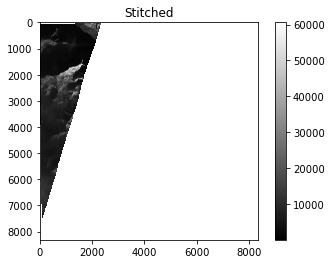

TILES FOR 20210209 1058
['/Volumes/SGlacier/Turner20_21/02_21/out/20210209_205636_73_1058_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210209_205638_73_1058_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.


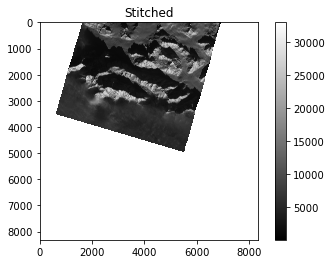

TILES FOR 20210209 240f
['/Volumes/SGlacier/Turner20_21/02_21/out/20210209_203314_95_240f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210209_203317_31_240f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210209_203319_66_240f_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.


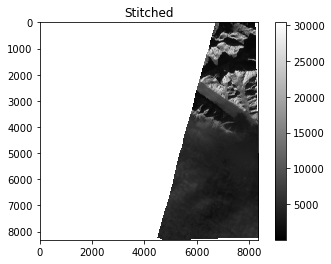

TILES FOR 20210210 0f17
['/Volumes/SGlacier/Turner20_21/02_21/out/20210210_201716_0f17_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_201717_0f17_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_201718_0f17_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_201719_0f17_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


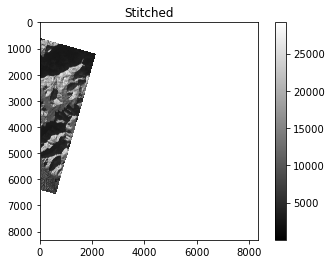

TILES FOR 20210210 227a
['/Volumes/SGlacier/Turner20_21/02_21/out/20210210_203812_44_227a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_203814_82_227a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_203817_19_227a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_203819_56_227a_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


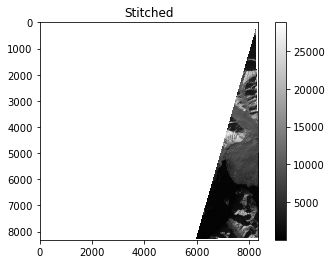

TILES FOR 20210210 2406
['/Volumes/SGlacier/Turner20_21/02_21/out/20210210_204256_18_2406_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_204258_46_2406_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_204300_75_2406_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210210_204303_04_2406_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


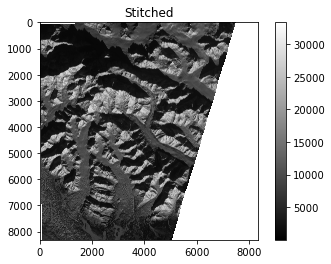

TILES FOR 20210211 1003
['/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201511_1003_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201512_1003_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201513_1003_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201514_1003_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


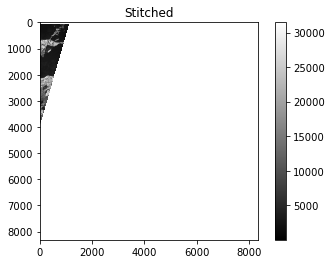

TILES FOR 20210211 101f
['/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201215_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201216_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201217_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201218_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201219_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201220_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201221_101f_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_201222_101f_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


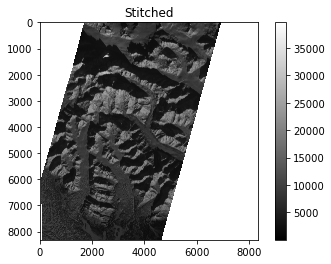

TILES FOR 20210211 2307
['/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203231_23_2307_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203233_59_2307_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203235_95_2307_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


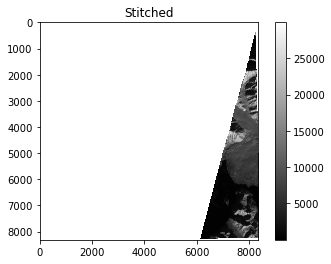

TILES FOR 20210211 2424
['/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203258_44_2424_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203300_78_2424_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203303_13_2424_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210211_203305_47_2424_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


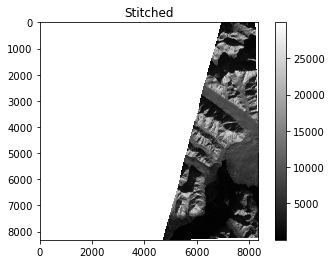

TILES FOR 20210212 241c
['/Volumes/SGlacier/Turner20_21/02_21/out/20210212_203613_77_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210212_203616_12_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210212_203618_47_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210212_203620_83_241c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210212_203623_18_241c_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


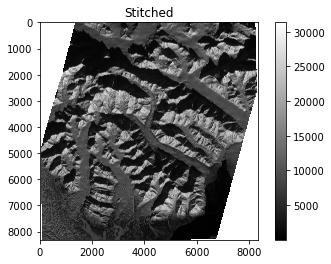

TILES FOR 20210213 1035
['/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200857_1035_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200858_1035_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200859_1035_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200900_1035_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200901_1035_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200902_1035_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_200903_1035_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


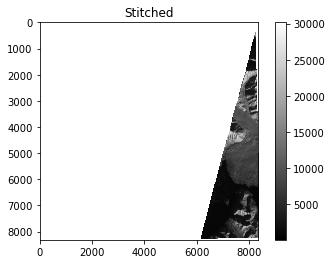

TILES FOR 20210213 106a
['/Volumes/SGlacier/Turner20_21/02_21/out/20210213_190438_42_106a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_190439_95_106a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_190441_48_106a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_190443_01_106a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_190444_53_106a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_190446_06_106a_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


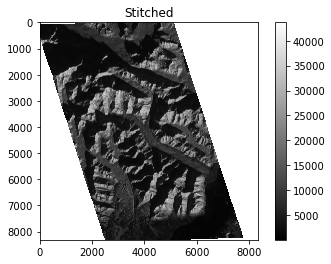

TILES FOR 20210213 240a
['/Volumes/SGlacier/Turner20_21/02_21/out/20210213_203850_06_240a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_203852_41_240a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_203854_76_240a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210213_203857_10_240a_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


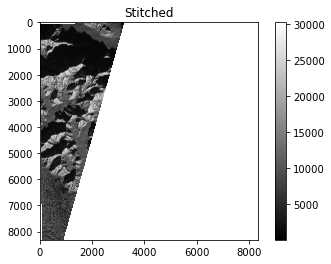

TILES FOR 20210214 1026
['/Volumes/SGlacier/Turner20_21/02_21/out/20210214_202512_1026_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_202513_1026_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.


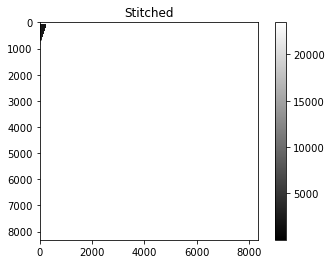

TILES FOR 20210214 1032
['/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201527_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201528_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201529_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201530_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201532_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201533_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201534_1032_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_201535_1032_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


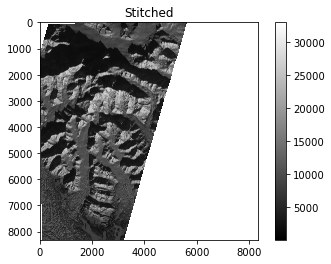

TILES FOR 20210214 2426
['/Volumes/SGlacier/Turner20_21/02_21/out/20210214_203903_65_2426_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_203905_92_2426_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_203908_18_2426_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210214_203910_45_2426_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


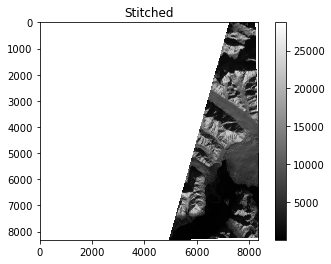

TILES FOR 20210215 100c
['/Volumes/SGlacier/Turner20_21/02_21/out/20210215_201134_100c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_201135_100c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_201136_100c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_201137_100c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_201138_100c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_201139_100c_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


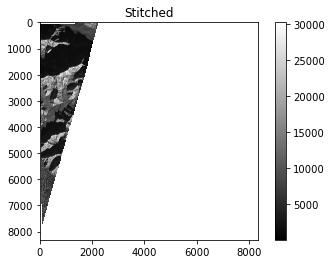

TILES FOR 20210215 1063
['/Volumes/SGlacier/Turner20_21/02_21/out/20210215_190732_25_1063_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_190733_77_1063_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_190735_30_1063_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_190736_83_1063_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_190738_35_1063_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_190739_88_1063_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.
Previous tile is larger.


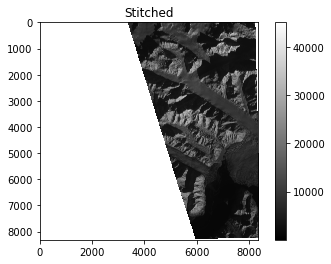

TILES FOR 20210215 2414
['/Volumes/SGlacier/Turner20_21/02_21/out/20210215_203810_40_2414_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_203812_67_2414_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_203814_94_2414_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_203817_21_2414_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


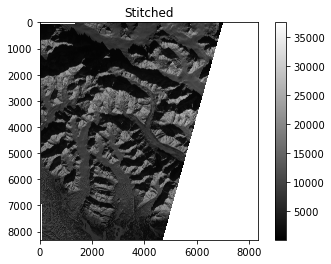

TILES FOR 20210215 2441
['/Volumes/SGlacier/Turner20_21/02_21/out/20210215_195302_22_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_195304_50_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_195306_77_2441_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210215_195309_04_2441_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.


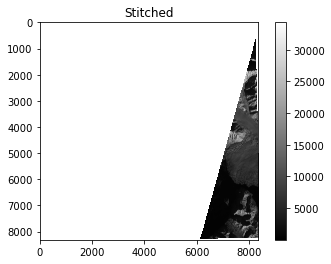

TILES FOR 20210216 1034
['/Volumes/SGlacier/Turner20_21/02_21/out/20210216_201612_1034_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210216_201613_1034_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210216_201614_1034_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


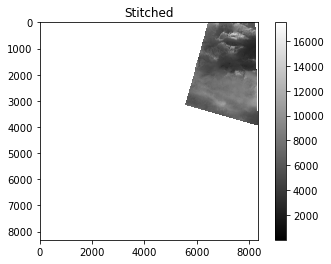

TILES FOR 20210216 106e
['/Volumes/SGlacier/Turner20_21/02_21/out/20210216_190429_33_106e_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210216_190430_86_106e_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.


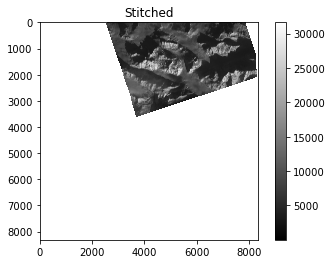

TILES FOR 20210216 2276
['/Volumes/SGlacier/Turner20_21/02_21/out/20210216_195837_94_2276_3B_AnalyticMS_SR_clip_5m.tif']


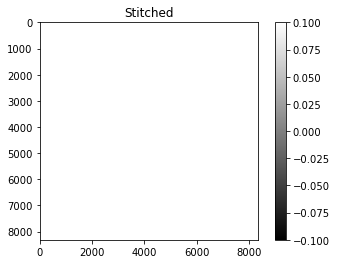

TILES FOR 20210216 240c
['/Volumes/SGlacier/Turner20_21/02_21/out/20210216_203817_20_240c_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210216_203819_48_240c_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.


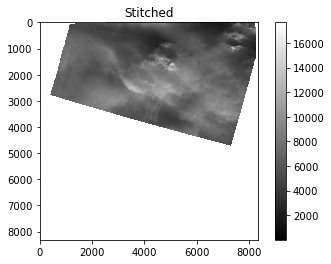

TILES FOR 20210218 1061
['/Volumes/SGlacier/Turner20_21/02_21/out/20210218_205134_72_1061_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210218_205140_72_1061_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.


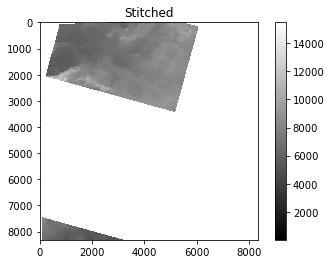

TILES FOR 20210221 227a
['/Volumes/SGlacier/Turner20_21/02_21/out/20210221_203543_76_227a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210221_203546_14_227a_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210221_203548_51_227a_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.
Previous tile is larger.


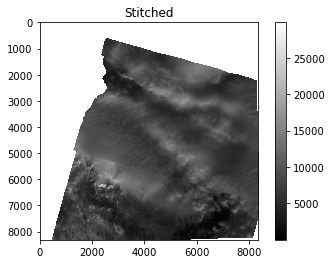

TILES FOR 20210222 1010
['/Volumes/SGlacier/Turner20_21/02_21/out/20210222_201109_1010_3B_AnalyticMS_SR_clip_5m.tif']


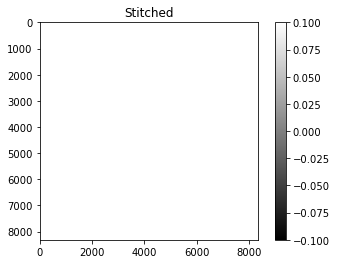

TILES FOR 20210222 2419
['/Volumes/SGlacier/Turner20_21/02_21/out/20210222_203704_40_2419_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210222_203709_11_2419_3B_AnalyticMS_SR_clip_5m.tif']
Previous tile is larger.


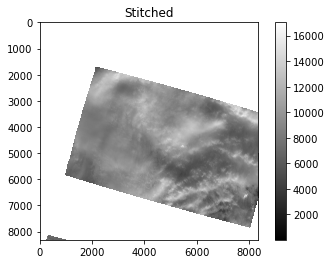

TILES FOR 20210223 2262
['/Volumes/SGlacier/Turner20_21/02_21/out/20210223_195150_89_2262_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_195153_37_2262_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_195155_86_2262_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_195158_34_2262_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_195200_82_2262_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


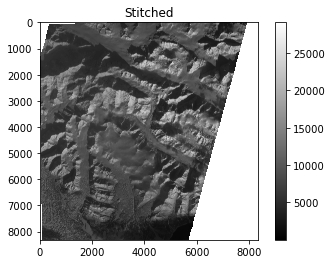

TILES FOR 20210223 2408
['/Volumes/SGlacier/Turner20_21/02_21/out/20210223_204003_12_2408_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_204005_39_2408_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_204007_67_2408_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210223_204009_94_2408_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.
Previous tile is larger.


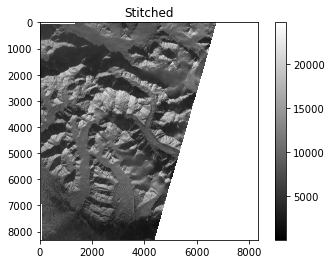

TILES FOR 20210224 1066
['/Volumes/SGlacier/Turner20_21/02_21/out/20210224_205434_74_1066_3B_AnalyticMS_SR_clip_5m.tif']


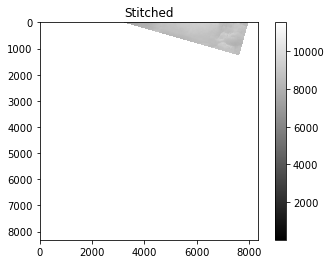

TILES FOR 20210226 0f22
['/Volumes/SGlacier/Turner20_21/02_21/out/20210226_201043_0f22_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210226_201044_0f22_3B_AnalyticMS_SR_clip_5m.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/20210226_201045_0f22_3B_AnalyticMS_SR_clip_5m.tif']
Current tile is larger.
Previous tile is larger.


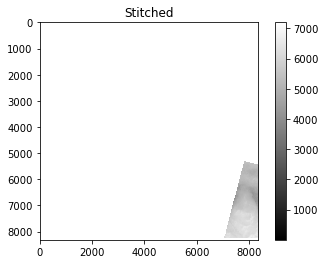

<IPython.core.display.Javascript object>

In [88]:
%%notify -m "Stitch by sat finished processing."

binary_thresh = 1
for date, ID in sorted_dates:  
    print('TILES FOR', date, ID)
    # Grab the Planet tiles corresponding to each unique date
    tiles = glob.glob(basepath+'/'+date+'*'+ID+'*SR_clip_5m.tif') # grab all file paths for that date
    tiles.sort()
    print(tiles)
    
    # initialize empty arrays
    overlap_total = np.zeros(reftile.shape);
    sr_stitched = np.zeros(reftile.shape) # start with empty stitched product
    t = 0 # tile count
    
    for tile in tiles:
        reader = rio.open(tile); sr = reader.read(1) # load the tile
        sr[sr == 0] = np.NaN # remove black background, replace with Nans
        sr_data = sr.copy() # make a copy of the data before making the data binary
        sr[sr>0.0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
        
        tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
        overlap_total = overlap_total+sr # add new overlap to overlap total
        
        if t==0: # just add the first one
            sr_stitched = np.nansum([sr_data, sr_stitched],0) # add them to the stitched product
        else:
            # for all subsequent, find the overlapping area:
            overlap_band = ma.masked_not_equal(overlap_total, 2) # identify non-overlapping area (not 2)
            overlap_band_mask = ma.getmaskarray(overlap_band)
            
            # identify which tile is larger
            if tilesize > prev_tilesize:
                print('Current tile is larger.')
                larger_tile = sr_data; smaller_tile = sr_stitched # assign the tiles
            elif tilesize < prev_tilesize:
                print('Previous tile is larger.')
                larger_tile = sr_stitched; smaller_tile = sr_data # assign the tiles
            else: # equal sizes
                print('Tiles are the same size.')
                larger_tile = sr_data; smaller_tile = sr_stitched # use current tile to coregister
                    
            # identify which overlapping tile is larger or smaller
            overlap_values_l = ma.masked_where(overlap_band_mask, larger_tile)
            overlap_values_larger = ~overlap_values_l.mask*overlap_values_l.data
            overlap_values_s = ma.masked_where(overlap_band_mask, smaller_tile)
            overlap_values_smaller = ~overlap_values_s.mask*overlap_values_s.data

            # remove overlap area from smaller tile and add to total
            smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile) 
            masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
            sr_stitched = np.nansum([masked_smaller_tile_coreg, larger_tile],0) 
            
        overlap_total[overlap_total > 1] = 1 # reset overlap total values to be 1
        # Store tile info for the next round of comparison
        prev_overlap = overlap_area # amount of pixels overlapping
        prev_tilesize = np.count_nonzero(sr_stitched) # previous tile size (pixels w/ data)
        sr_prev = sr_data
        sr_stitched[sr_stitched == 0]=np.NaN # fill black pixels with NaNs
        t += 1 # increment tile count
        
    # Plot final stitched image
    fig = plt.figure(); im = plt.imshow(sr_stitched, cmap='gray'); plt.title('Stitched'); 
    fig.colorbar(im); plt.show()
    
    # Export stitched image
    outfilename = 'PS_'+date+'_'+ID+'.tif'
    if not os.path.exists(basepath+"stitched_by_sat/"):
        os.mkdir(basepath+"stitched_by_sat/")
    with rio.open(basepath+"stitched_by_sat/"+outfilename,'w',
                      driver='GTiff',
                      height=sr_stitched.shape[0], # new shape
                      width=sr_stitched.shape[1], # new shape
                      dtype=sr_stitched.dtype, # data type
                      count=1,
                      crs=reftile.crs, # the EPSG from the original DEM
                      transform=reftile.transform) as dst:
            dst.write(sr_stitched, 1)
    del overlap_total; del sr_stitched # clear variables
    

# Stitch together all satellite chunks for each date

Grid of mask does not match images. Resampling.
Resampled to new dimensions: (8315, 8357)


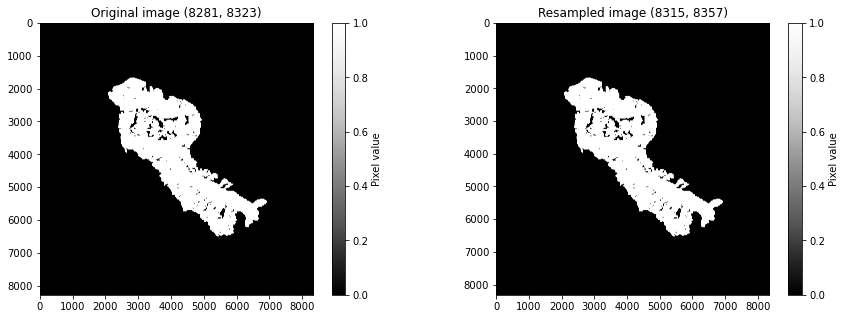

In [89]:
# Read in glacier mask (rasterized) - must be in the same projection as the plane images (UTM)
mask_path = '/Volumes/SGlacier/TG_autorift_inputs/TG_mask_5m.tif'
mask_reader = rio.open(mask_path); glacier_mask = mask_reader.read(1) # load the tile
glacier_mask[glacier_mask == 0] = np.NaN # remove black background, replace with Nans
glacier_mask[glacier_mask>0.0] = 1 ; glacier_mask[np.isnan(glacier_mask)] = 0 # make binary

if reftile.crs != mask_reader.crs: # Check that projections match
    print('ERROR: CRS of mask does not match images.')

# put both on same grid if they aren't already
if mask_reader.transform[0] != reftile.transform[0] or mask_reader.shape != reftile.shape:
    print('Grid of mask does not match images. Resampling.')
    
    # grab grids
    ref_x = np.linspace(reftile.bounds.left, reftile.bounds.right, num=np.shape(reftile)[1])
    ref_y = np.linspace(reftile.bounds.top, reftile.bounds.bottom, num=np.shape(reftile)[0])
    mask_x = np.linspace(mask_reader.bounds.left, mask_reader.bounds.right, num=np.shape(glacier_mask)[1])
    mask_y = np.linspace(mask_reader.bounds.top, mask_reader.bounds.bottom, num=np.shape(glacier_mask)[0])
    mask_resamp = np.zeros((len(ref_y), len(ref_x))) # create an empty resampled img grid

    # Resample to your new DEM bounds
    f = interp2d(mask_x, mask_y, glacier_mask) # create DEM interpolation object
    mask_resamp = f(ref_x,ref_y) # resample the NIR data to the DSM coordinates
    mask_resamp = np.flipud(mask_resamp) # flip up down
    print("Resampled to new dimensions:", mask_resamp.shape)

    # Display the original and resampled images as a visual check
    fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))
    im1 = ax1.imshow(glacier_mask, cmap='Greys_r', vmin=0)
    ax1.set_title('Original image '+str(mask_reader.shape))
    fig.colorbar(im1, ax=ax1,label='Pixel value')
    im2 = ax2.imshow(mask_resamp, cmap='Greys_r', vmin=0)
    ax2.set_title('Resampled image '+str(mask_resamp.shape))
    fig.colorbar(im2, ax=ax2,label='Pixel value')
    plt.show()

In [90]:
# grab all the unique dates
dates = []
for file in os.listdir(basepath+'stitched_by_sat/'): # path
    date = file.split('_')[1] # grab the date from the file name
    dates.append(date)
unique_dates = list(set(dates)) # save a list of the dates
unique_dates.sort() # sort the dates
print(unique_dates)

['20210201', '20210202', '20210203', '20210204', '20210205', '20210206', '20210207', '20210208', '20210209', '20210210', '20210211', '20210212', '20210213', '20210214', '20210215', '20210216', '20210218', '20210221', '20210222', '20210223', '20210224', '20210226']


TILES FOR 20210201
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210201_1034.tif']


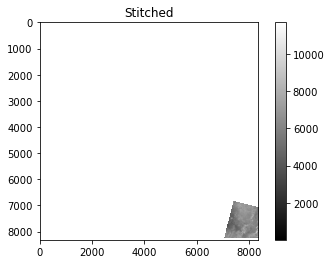

TILES FOR 20210202
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210202_2235.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210202_1060.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210202_1014.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210202_2441.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210202_241c.tif']


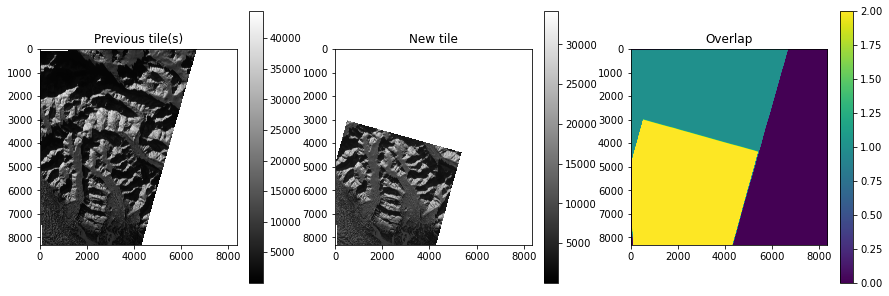

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -463.41636579234455
New mean diff: 0.0


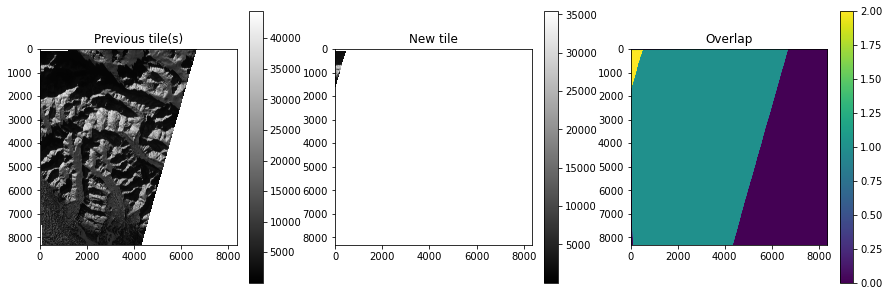

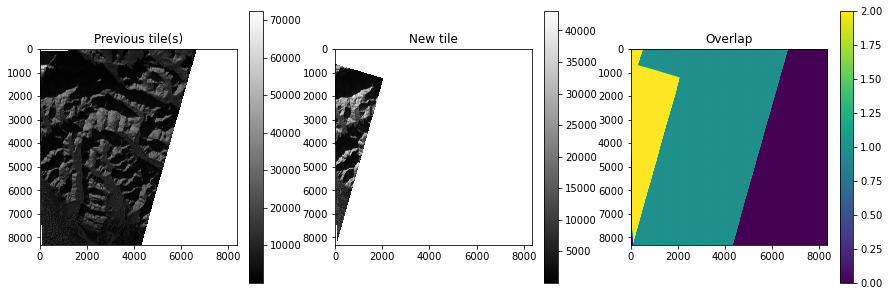

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -230.04617791374858
New mean diff: 0.0


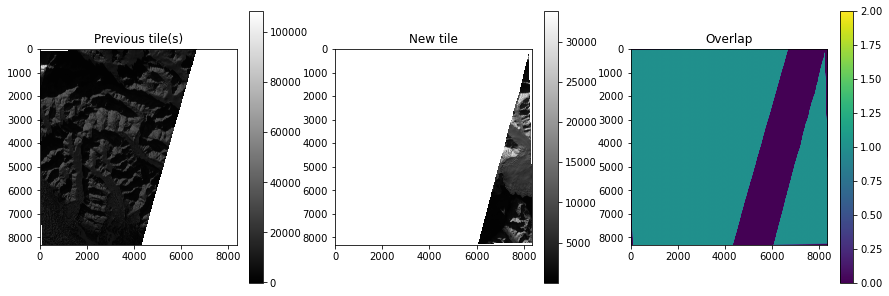

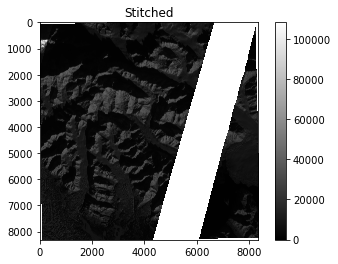

TILES FOR 20210203
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210203_1064.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210203_2408.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210203_2405.tif']


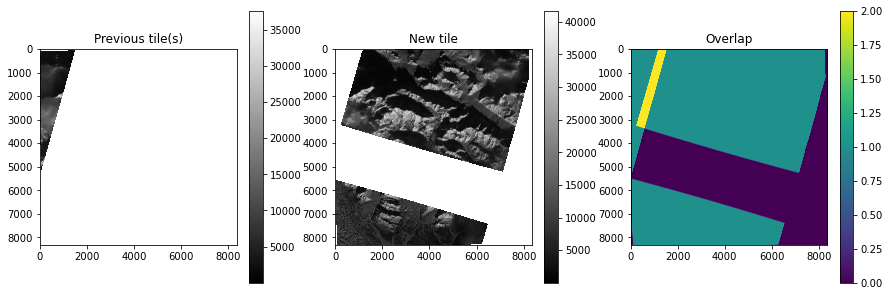

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 638.4404613977533
New mean diff: 0.0


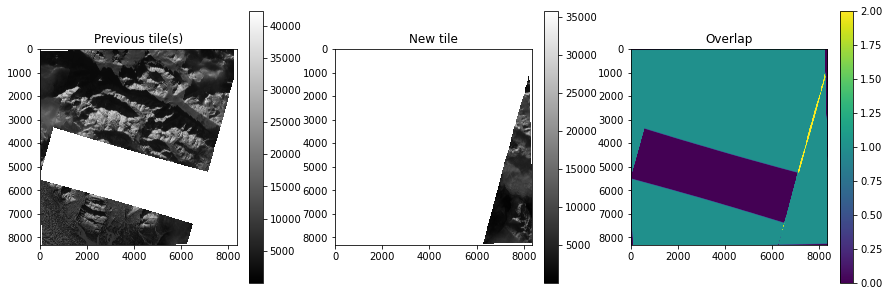

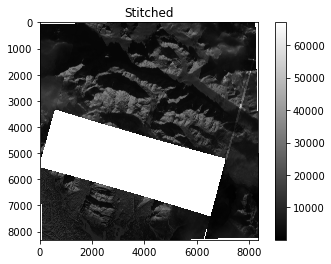

TILES FOR 20210204
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210204_1059.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210204_105c.tif']


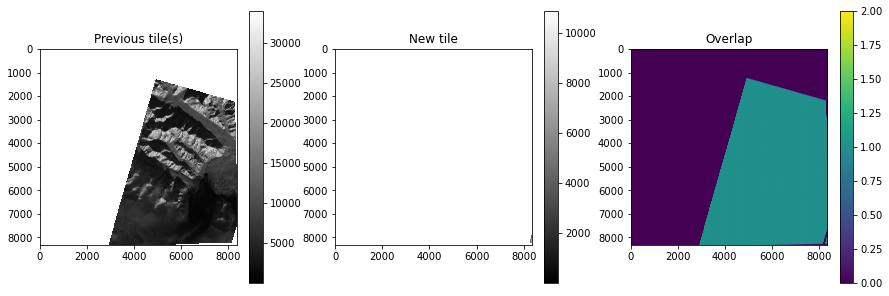

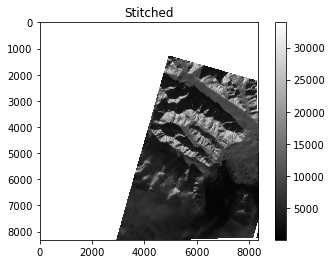

TILES FOR 20210205
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210205_105c.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210205_1040.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210205_2412.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210205_105d.tif']


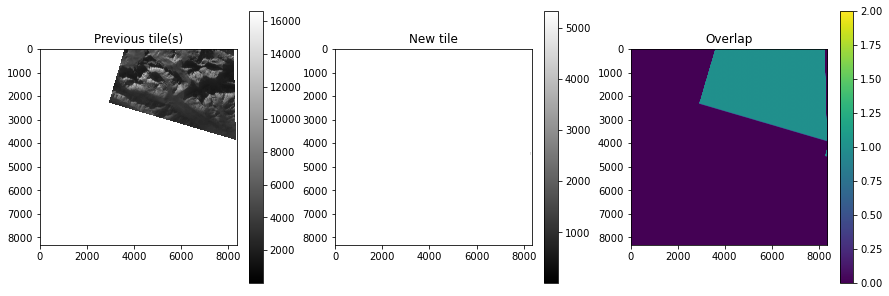

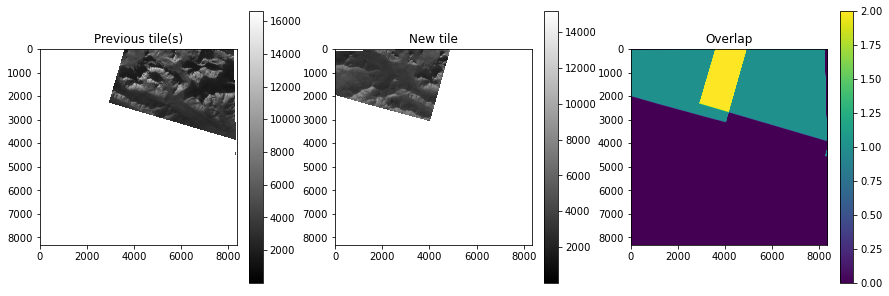

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -253.96741328079088
New mean diff: 0.0


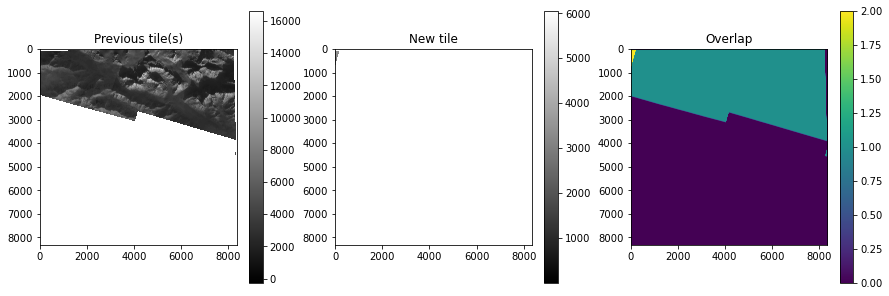

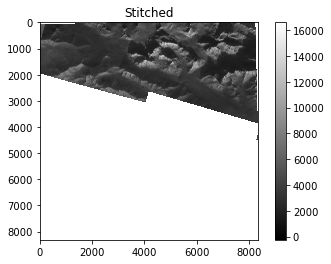

TILES FOR 20210206
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210206_240a.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210206_2402.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210206_1057.tif']


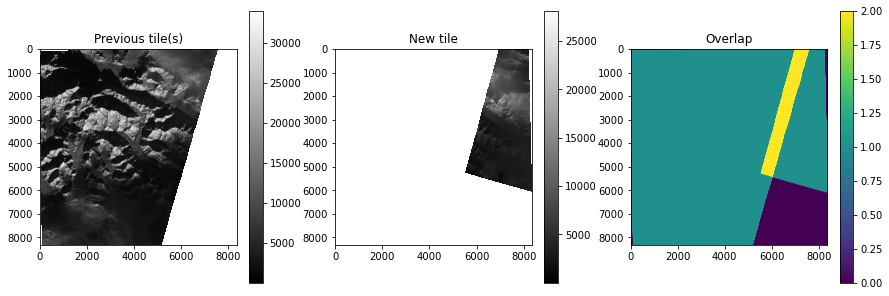

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 251.30624065344944
New mean diff: 0.0


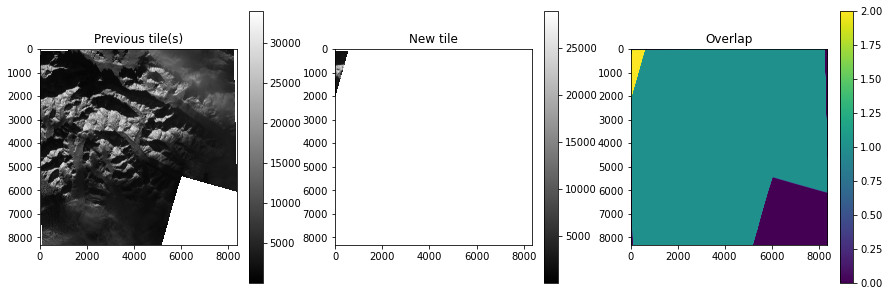

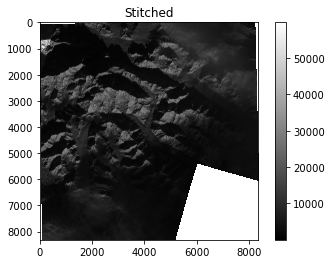

TILES FOR 20210207
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210207_101f.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210207_1066.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210207_0e0f.tif']


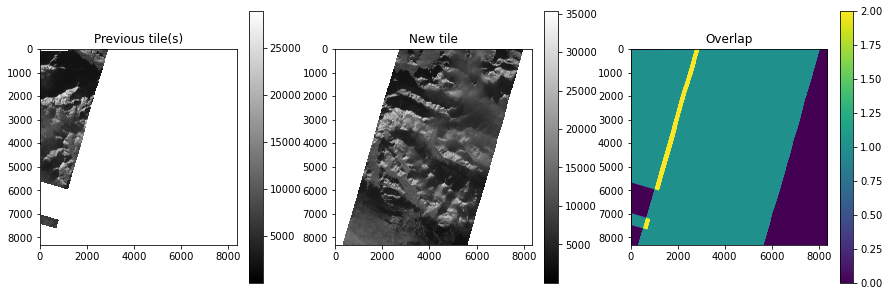

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -1237.1739121862292
New mean diff: 0.0


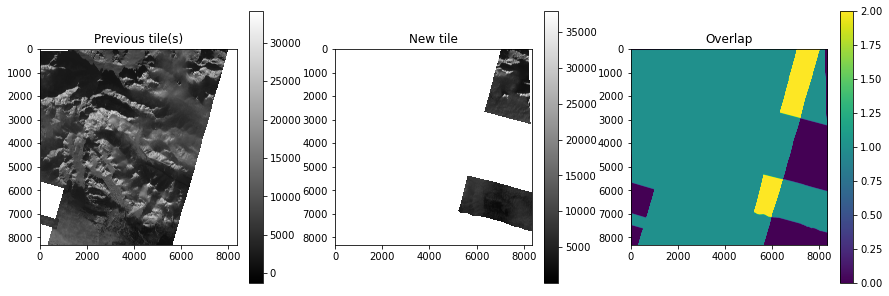

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -1636.0946184430113
New mean diff: 0.0


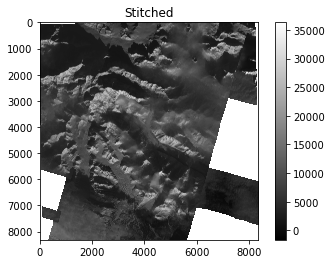

TILES FOR 20210208
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210208_225b.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210208_2441.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210208_105a.tif']


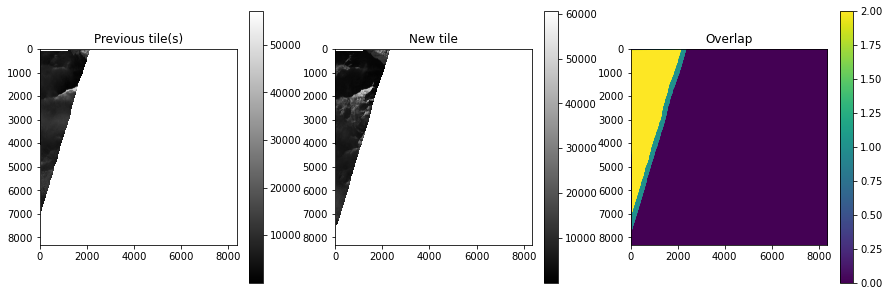

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 1252.1747858134304
New mean diff: 0.0


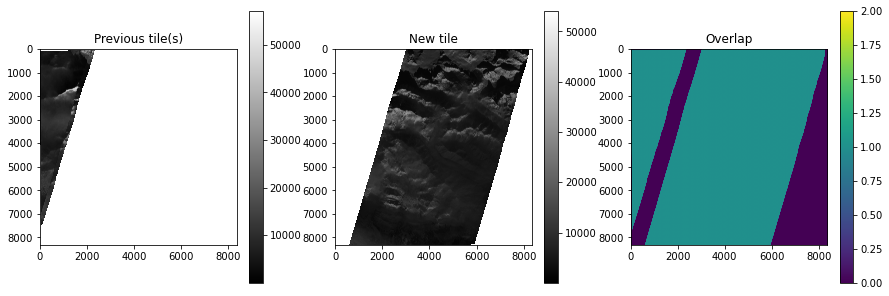

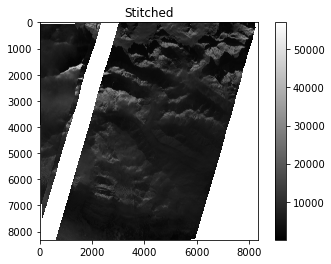

TILES FOR 20210209
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210209_1058.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210209_240f.tif']


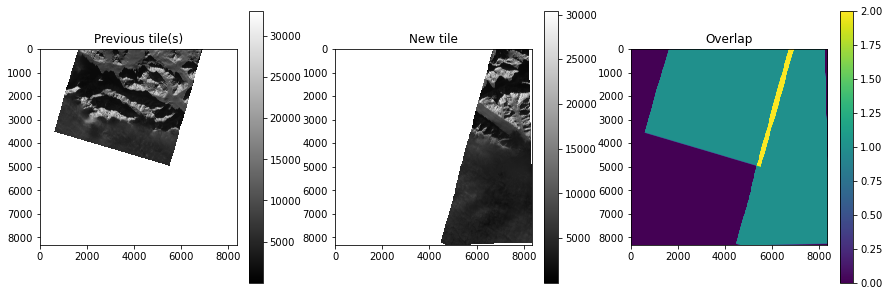

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 515.4217441853912
New mean diff: 0.0


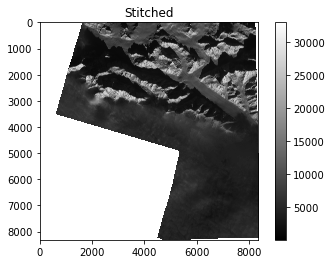

TILES FOR 20210210
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210210_2406.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210210_227a.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210210_0f17.tif']


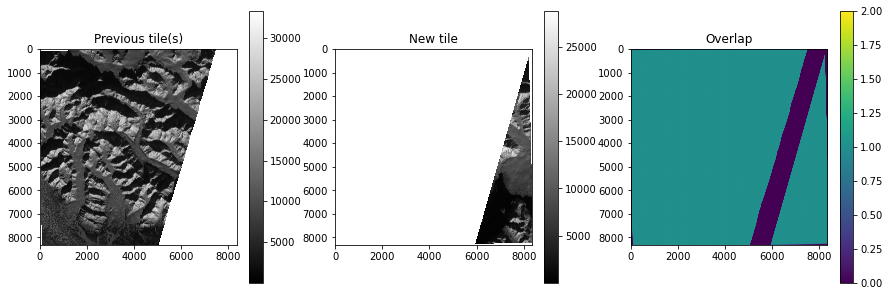

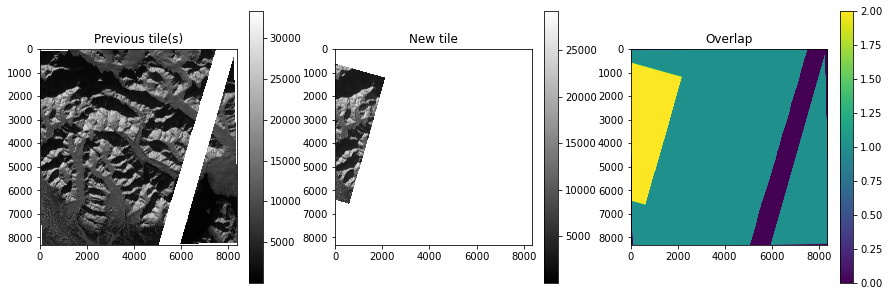

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -1074.029303823706
New mean diff: 0.0


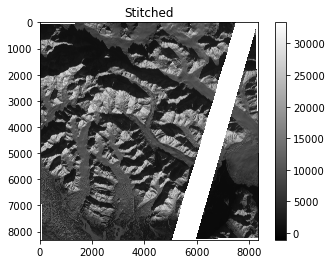

TILES FOR 20210211
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210211_2307.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210211_1003.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210211_101f.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210211_2424.tif']


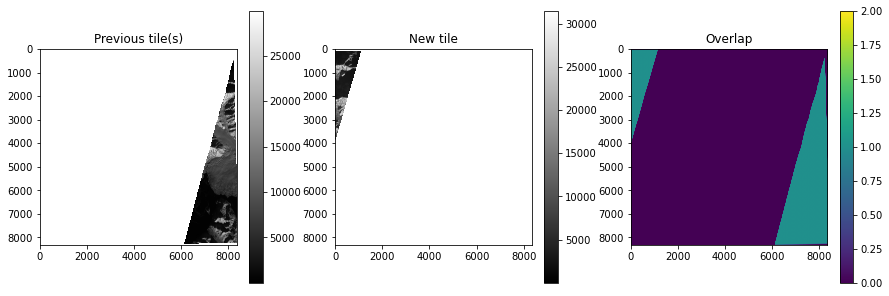

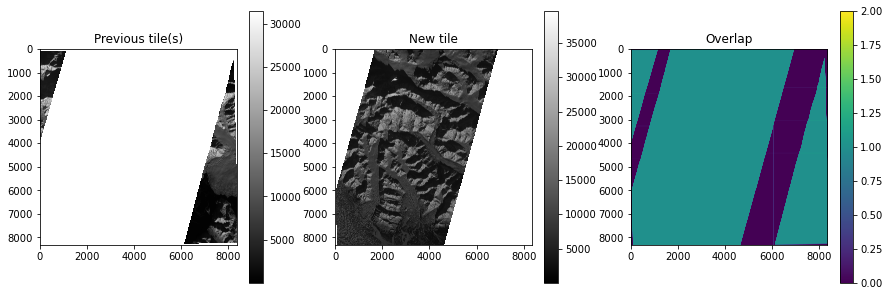

Current tile is larger.
Mean difference in values from the larger tile in overlap area: 280.61783572893273
New mean diff: 0.0


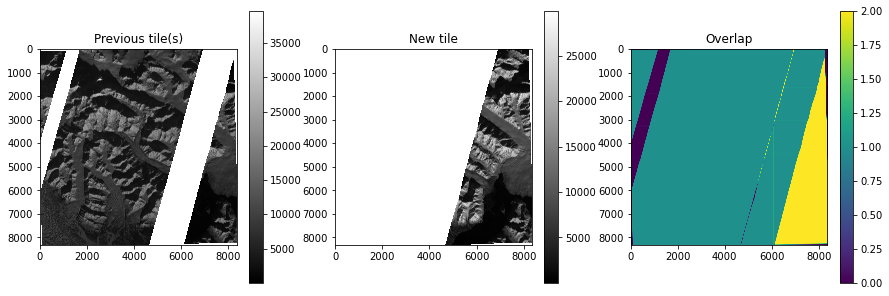

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 174.22014531490822
New mean diff: 0.0


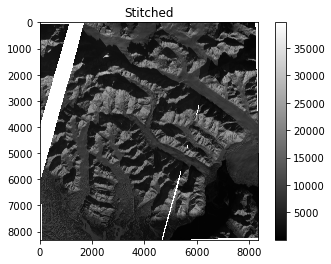

TILES FOR 20210212
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210212_241c.tif']


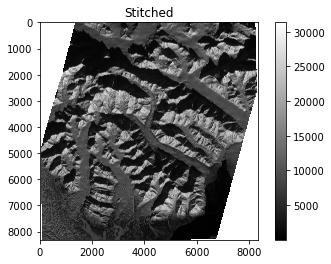

TILES FOR 20210213
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210213_106a.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210213_240a.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210213_1035.tif']


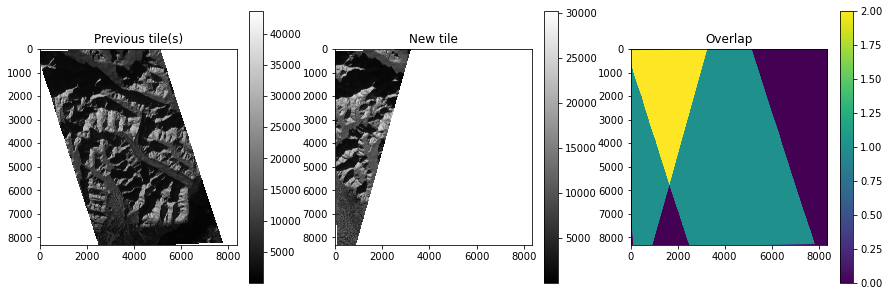

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 435.6731647293018
New mean diff: 0.0


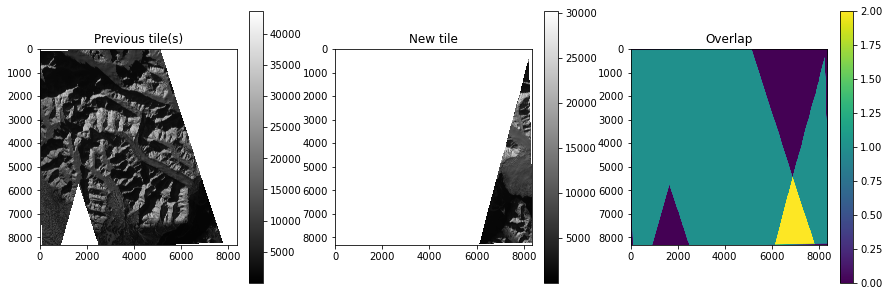

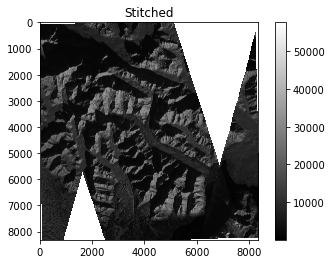

TILES FOR 20210214
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210214_2426.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210214_1032.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210214_1026.tif']


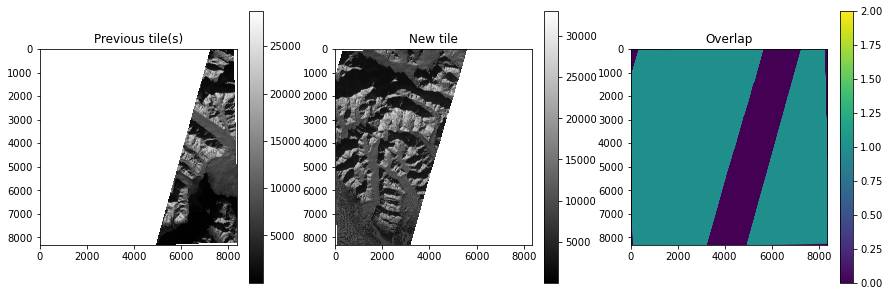

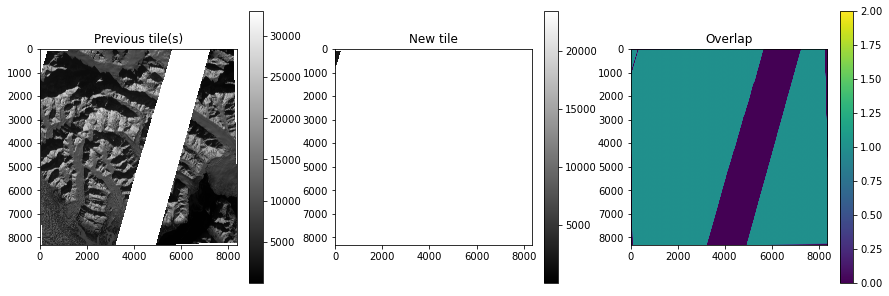

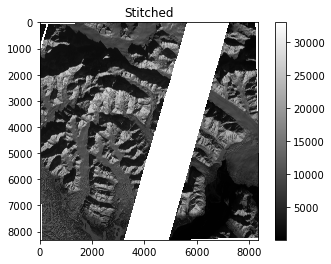

TILES FOR 20210215
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210215_1063.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210215_2441.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210215_100c.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210215_2414.tif']


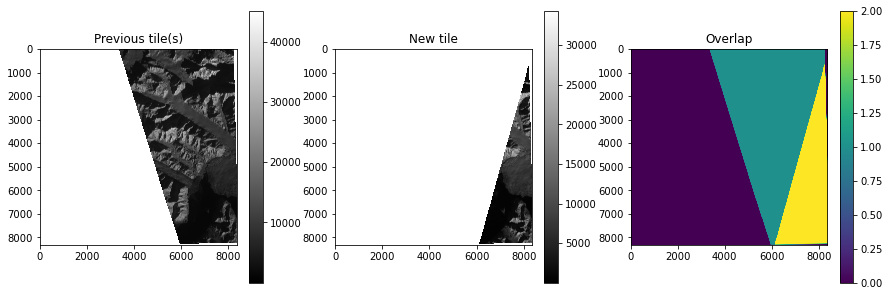

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 703.1876320280433
New mean diff: 0.0


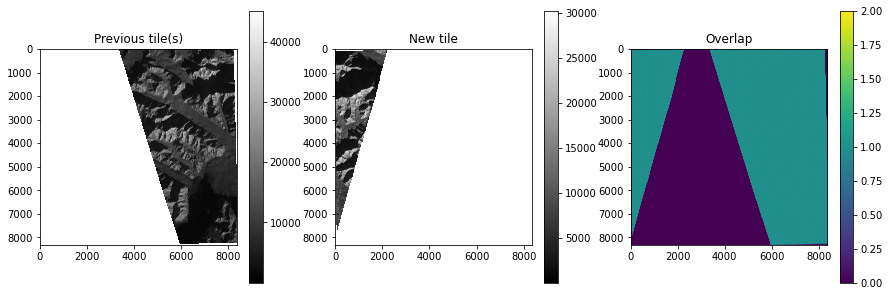

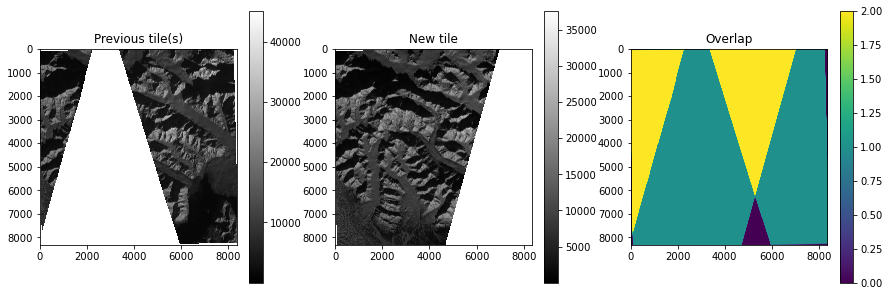

Current tile is larger.
Mean difference in values from the larger tile in overlap area: -863.4370370407231
New mean diff: 0.0


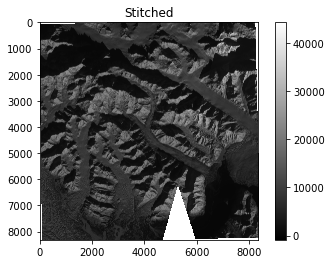

TILES FOR 20210216
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210216_2276.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210216_1034.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210216_240c.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210216_106e.tif']


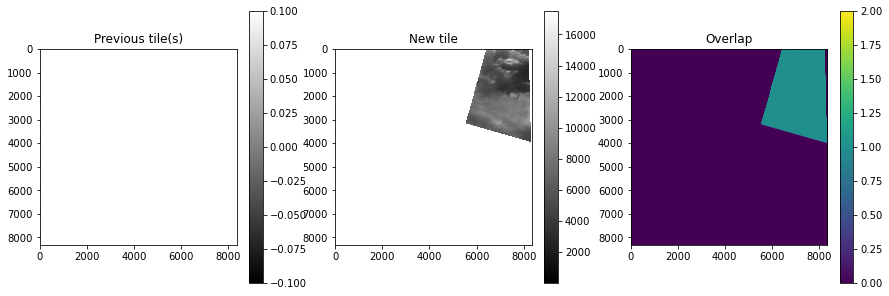

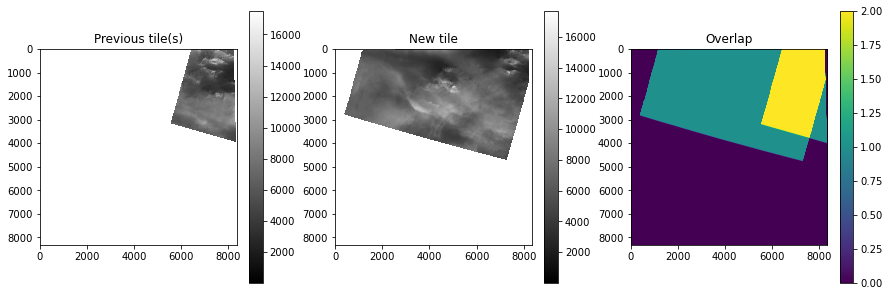

Current tile is larger.
Mean difference in values from the larger tile in overlap area: 168.52812561521114
New mean diff: 0.0


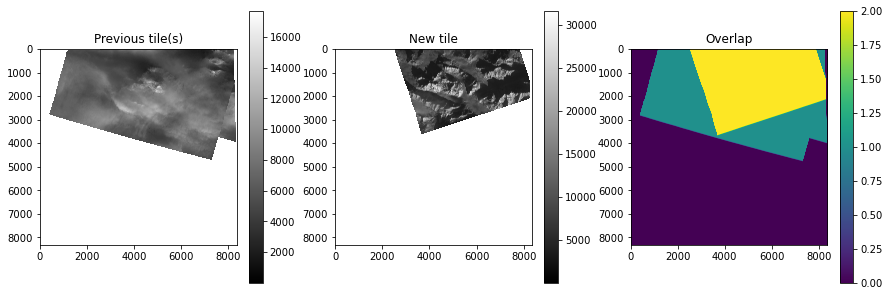

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: -823.1866039141914
New mean diff: 0.0


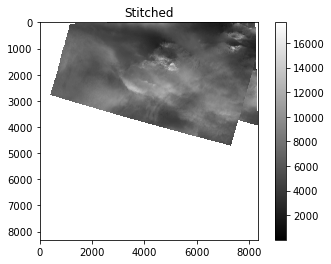

TILES FOR 20210218
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210218_1061.tif']


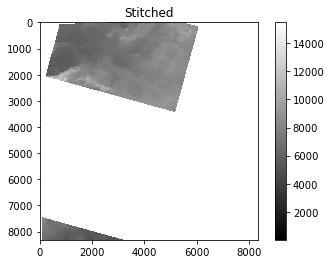

TILES FOR 20210221
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210221_227a.tif']


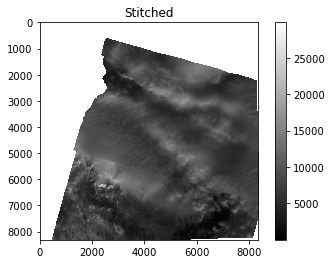

TILES FOR 20210222
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210222_2419.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210222_1010.tif']


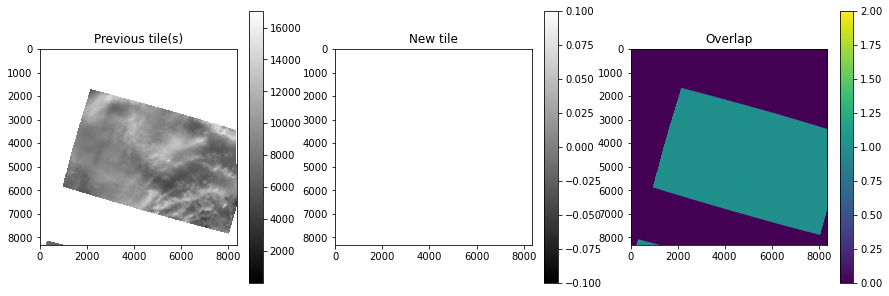

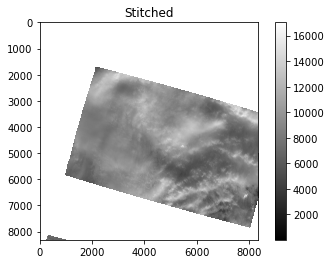

TILES FOR 20210223
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210223_2262.tif', '/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210223_2408.tif']


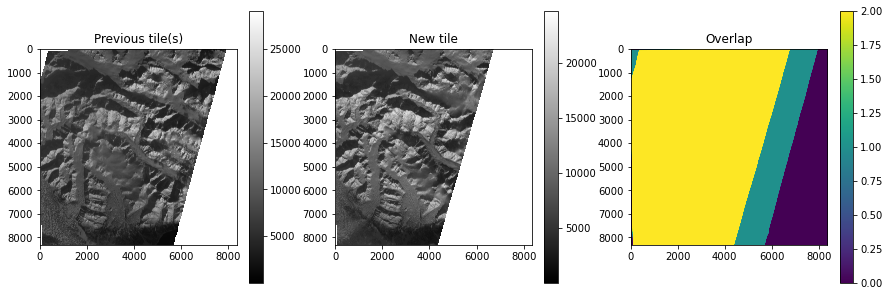

Previous tile is larger.
Mean difference in values from the larger tile in overlap area: 327.19046874423134
New mean diff: 0.0


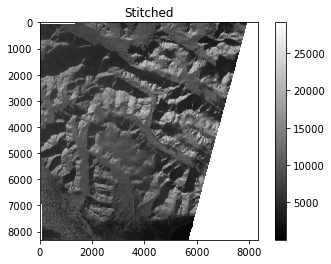

TILES FOR 20210224
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210224_1066.tif']


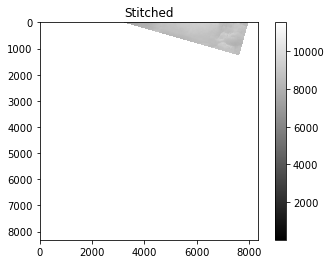

TILES FOR 20210226
['/Volumes/SGlacier/Turner20_21/02_21/out/stitched_by_sat/PS_20210226_0f22.tif']


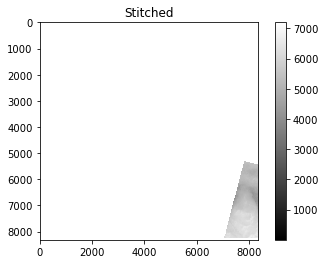

<IPython.core.display.Javascript object>

In [91]:
%%notify -m "Stitch sat chunks finished."

for date in unique_dates:  
    print('TILES FOR', date)
    tiles = glob.glob(basepath+'stitched_by_sat/PS_'+date+'*.tif') # grab all file paths for that date
    print(tiles)
    
    # initialize empty arrays
    overlap_total = np.zeros(reftile.shape);
    sr_stitched = np.zeros(reftile.shape) # start with empty stitched product
    t = 0 # tile count
    
    for tile in tiles:
        reader = rio.open(tile); sr = reader.read(1) # load the tile
        sr[sr == 0] = np.NaN # remove black background, replace with Nans
        sr_data = sr.copy() # make a copy of the data before making the data binary
        sr[sr>0.0] = 1 ; sr[np.isnan(sr)] = 0 # make tile binary
        
        tilesize = np.count_nonzero(sr) # grab the current tile size (pixels)
        overlap_total = overlap_total+sr # add new overlap to overlap total
        
        if t == 0: # for the first tile
            sr_stitched = sr_stitched+sr_data # add the data to sr_stitched
            overlap_area = 0 # no overlap area for the first tile
        
        else: # for all subsequent tiles, do iterative normalization based on overlapping area, if any
            overlap_area = np.count_nonzero(overlap_total[overlap_total >= 2]) # update total overlap area
            
            # Plot the tile comparison and overlap
            fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(15,5))
            im1 = ax1.imshow(sr_stitched,cmap='gray'); ax1.set_title('Previous tile(s)'); fig.colorbar(im1,ax=ax1)
            im2 = ax2.imshow(sr_data,cmap='gray'); ax2.set_title('New tile'); fig.colorbar(im2, ax=ax2)
            im3 = ax3.imshow(overlap_total,vmin=0,vmax=2); ax3.set_title('Overlap'); fig.colorbar(im3,ax=ax3)
            plt.show()
            
            # if the total overlap area has increased (i.e., new overlap)
            if overlap_area > prev_overlap: # increase in overlapping area indicates we have 2 overlapping tiles!!!
                overlap_band = ma.masked_not_equal(overlap_total, 2) # identify non-overlapping area (not 2)
                overlap_band_mask = ma.getmaskarray(overlap_band) # grab the mask for the overlapping area
                
                # identify which tile is larger
                if tilesize > prev_tilesize:
                    print('Current tile is larger.')
                    larger_tile = sr_data; smaller_tile = sr_stitched # assign the tiles
                elif tilesize < prev_tilesize:
                    print('Previous tile is larger.')
                    larger_tile = sr_stitched; smaller_tile = sr_data # assign the tiles
                else: # equal sizes
                    print('Tiles are the same size.')
                    larger_tile = sr_data; smaller_tile = sr_stitched # use current tile to coregister
                
                # grab mean pixel difference from overlapping area (ON GLACIER)
                overlap_values_l = ma.masked_where(overlap_band_mask, larger_tile)
                overlap_values_larger = ~overlap_values_l.mask*overlap_values_l.data
                overlap_values_s = ma.masked_where(overlap_band_mask, smaller_tile)
                overlap_values_smaller = ~overlap_values_s.mask*overlap_values_s.data
                diff = np.nanmedian(np.subtract(overlap_values_larger,overlap_values_smaller)) # median diff
                print('Mean difference in values from the larger tile in overlap area:', diff)
                
                # mean difference in overlapping area over glacier
                overlap_glacier_l = ma.masked_where(glacier_ice_mask, overlap_values_larger)
                overlap_glacier_larger = overlap_glacier_l.mask*overlap_glacier_l.data
                overlap_glacier_s = ma.masked_where(glacier_ice_mask, overlap_values_smaller)
                overlap_glacier_smaller = overlap_glacier_s.mask*overlap_glacier_s.data
                diff2 = np.nanmedian(np.subtract(overlap_glacier_larger,overlap_glacier_smaller))
                print('New mean diff:', diff2)
                
                if diff2 != 0: # if there is glacier overlap, only shift with glacier difference
                    
                    # normalize the smaller tile's values to the larger reference tile's overlap values
                    smaller_tile_coreg = smaller_tile + diff2 # add the mean difference to all values
                    smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile_coreg) 

                    # remove overlap area from smaller tile:
                    masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
                    
#                     # SHOW THE OVERLAPPING AREA:
#                     plt.imshow(overlap_glacier_smaller); plt.colorbar(); plt.show()
                    
                else: # If not, shift with overlapping difference
                    smaller_tile_coreg = smaller_tile + diff # add the mean difference to all values
                    smaller_tile_coreg = ma.masked_where(~overlap_band_mask, smaller_tile_coreg) 

                    # remove overlap area from smaller tile:
                    masked_smaller_tile_coreg = ~smaller_tile_coreg.mask*smaller_tile_coreg.data
                  
                # add them to the stitched produdct
                sr_stitched = np.nansum([masked_smaller_tile_coreg, larger_tile],0) 
                overlap_total[overlap_total > 0] = 1 # refresh overlap total
            else: # if no overlap, just add them without doing anything
                sr_stitched = np.nansum([sr_data, sr_stitched],0) # add them to the stitched product

        # Store tile info for the next round of comparison
        prev_overlap = overlap_area # amount of pixels overlapping
        prev_tilesize = np.count_nonzero(sr_stitched) # previous tile size (pixels w/ data)
        sr_prev = sr_data
        sr_stitched[sr_stitched == 0]=np.NaN # fill black pixels with NaNs
        t += 1 # increment tile count
        
    # Plot final stitched image
    fig = plt.figure(); im = plt.imshow(sr_stitched, cmap='gray'); plt.title('Stitched'); 
    fig.colorbar(im); plt.show()

    # Export stitched image
    outfilename = 'PS_'+date+'.tif'
    if not os.path.exists(basepath+"stitched_images/"):
        os.mkdir(basepath+"stitched_images/")
    with rio.open(basepath+"stitched_images/"+outfilename,'w',
                        driver='GTiff',
                        height=sr_stitched.shape[0], # new shape
                        width=sr_stitched.shape[1], # new shape
                        dtype=sr_stitched.dtype, # data type
                        count=1,
                        crs=reftile.crs, # the EPSG from the original DEM
                        transform=reftile.transform) as dst:
            dst.write(sr_stitched, 1)
    #break
    del overlap_total; del sr_stitched # clear variables
    

# Remove those images that cover less than 50% of the glacier and crop images to the bounding box

In [92]:
# Read glacier shapefile
with fiona.open('/Volumes/SGlacier/BoxTurner/BoxTurner_UTM_07.shp', "r") as shapefile:
    shapes = [feature["geometry"] for feature in shapefile]

In [93]:
stitchedpath = basepath+'stitched_images/' # path to the stitched images
boxpath = '/Volumes/SGlacier/BoxTurner/BoxTurner_UTM_07.shp' # path to bounding box shapefile

# multiply each image by glacier mask
for file in os.listdir(stitchedpath):
    if file.startswith('PS') and not file.endswith('clipped.tif'):
        print(file)
        
        # read image file and crop to glacier outline
        with rio.open(stitchedpath+file) as src:
            out_image, out_transform = mask(src, shapes, crop=True)

        # calculate number of non-empty pixels over the glacier
        total_pixels = np.count_nonzero(out_image[0])
        out_image[np.isnan(out_image)] = 0 # set all Nans to 0
        pixels_w_data = np.count_nonzero(out_image) # count non nans (number of pixels with data)
        
        # print data percent
        data_percent = int(pixels_w_data/total_pixels*100)
        print(data_percent, '%')
        
        # remove if it does exist:
        if file[:-4]+'_clipped.tif' in os.listdir(stitchedpath):
            os.remove(stitchedpath+file[:-4]+'_clipped.tif')
            
        # if data percent > 50, and clipped version doesn't already exist:
        if data_percent >= 50: #and not file[:-4]+'_clipped.tif' in os.listdir(stitchedpath):
            # Crop file
            crop_cmd = 'gdalwarp -cutline '+boxpath+' -crop_to_cutline '
            crop_cmd += stitchedpath+file+' '+stitchedpath+file[:-4]+'_clipped.tif'
            print(crop_cmd); print()

            subprocess.run(crop_cmd,shell=True,check=True); print()
        else:
            print('Uncomment line 33 to remove', file)
            
#             # remove the file
#             
            
    

PS_20210213.tif
98 %
gdalwarp -cutline /Volumes/SGlacier/BoxTurner/BoxTurner_UTM_07.shp -crop_to_cutline /Volumes/SGlacier/Turner20_21/02_21/out/stitched_images/PS_20210213.tif /Volumes/SGlacier/Turner20_21/02_21/out/stitched_images/PS_20210213_clipped.tif

Creating output file that is 8357P x 8315L.
Processing /Volumes/SGlacier/Turner20_21/02_21/out/stitched_images/PS_20210213.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

PS_20210207.tif
92 %
gdalwarp -cutline /Volumes/SGlacier/BoxTurner/BoxTurner_UTM_07.shp -crop_to_cutline /Volumes/SGlacier/Turner20_21/02_21/out/stitched_images/PS_20210207.tif /Volumes/SGlacier/Turner20_21/02_21/out/stitched_images/PS_20210207_clipped.tif

Creating output file that is 8357P x 8315L.
Processing /Volumes/SGlacier/Turner20_21/02_21/out/stitched_images/PS_20210207.tif [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

PS_20210206.tif
88 %
gdalwarp -cutline /Volumes/SGlacier/BoxTurner/BoxTurner_UTM_07.shp -c

# Move all good clipped images into new folder (temporary)

In [94]:
# for file in os.listdir('/Volumes/SGlacier/TG_20_21/'):
#     print(file.split('_')[1][2:3]) # year
#     print(file.split('_')[1][4:5]) # mo
    
#     searchpath = '/Volumes/SGlacier/Turner20_21/'+mo+'_'+yy+'/'
    
#     # if found, move into the folder
#     for searchfile in os.listdir(searchpath):
#         if searchfile == file:
#             shutil.copy(searchpath+searchfile, '/Volumes/SGlacier/TG_20_21/'+searchfile)